# Task description:
- Experiment with the number of hidden neurons and the learning rate. Which changes produce a linear output behaviour and which changes lead to strong "overfitting"?

# Implementation:

In [49]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

Load the data

In [50]:
# set the printing options for Tensor objects in PyTorch to display only the first and last 
# two elements and limit the line width to 75 characters for improved readability.
torch.set_printoptions(edgeitems=2, linewidth=75) 

# load data
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# make them a two dimensional tensor by adding a dimension
# size: len(t_u) -> size: [len(t_u), 1]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1) 

print("shape of t_u:", t_u.shape)

shape of t_u: torch.Size([11, 1])


Split the dataset in training and validation data

In [51]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples) # 20% der testdaten sind Validierungsdaten

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print("train_indices:", train_indices)
print("val_indices:", val_indices)

train_indices: tensor([ 1,  7,  3,  2,  0, 10,  6,  5,  4])
val_indices: tensor([9, 8])


In [52]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

Definition of the training loop

In [53]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


Definition of the sequential model

In [54]:
num_neurons = 8 # ruhig hier mal Werte zwischen 1 und 20000 ausprobieren (eigentlich 8)

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, num_neurons)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(num_neurons, 1))
]))

print("Model:",seq_model)

for name, param in seq_model.named_parameters():
    print(name, param.shape)

Model: Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)
hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [55]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 183.5955, Validation loss 82.8426
Epoch 1000, Training loss 4.2769, Validation loss 9.6307
Epoch 2000, Training loss 3.1975, Validation loss 16.9468
Epoch 3000, Training loss 1.9067, Validation loss 11.2856
Epoch 4000, Training loss 1.5254, Validation loss 8.7778
Epoch 5000, Training loss 1.4176, Validation loss 7.8161
output tensor([[15.2486],
        [ 7.7016]], grad_fn=<AddmmBackward0>)
answer tensor([[13.],
        [ 6.]])
hidden tensor([[  0.9731],
        [  9.2616],
        [ -0.0222],
        [ 10.4768],
        [ -0.2903],
        [-11.4596],
        [  1.0565],
        [-10.5305]])


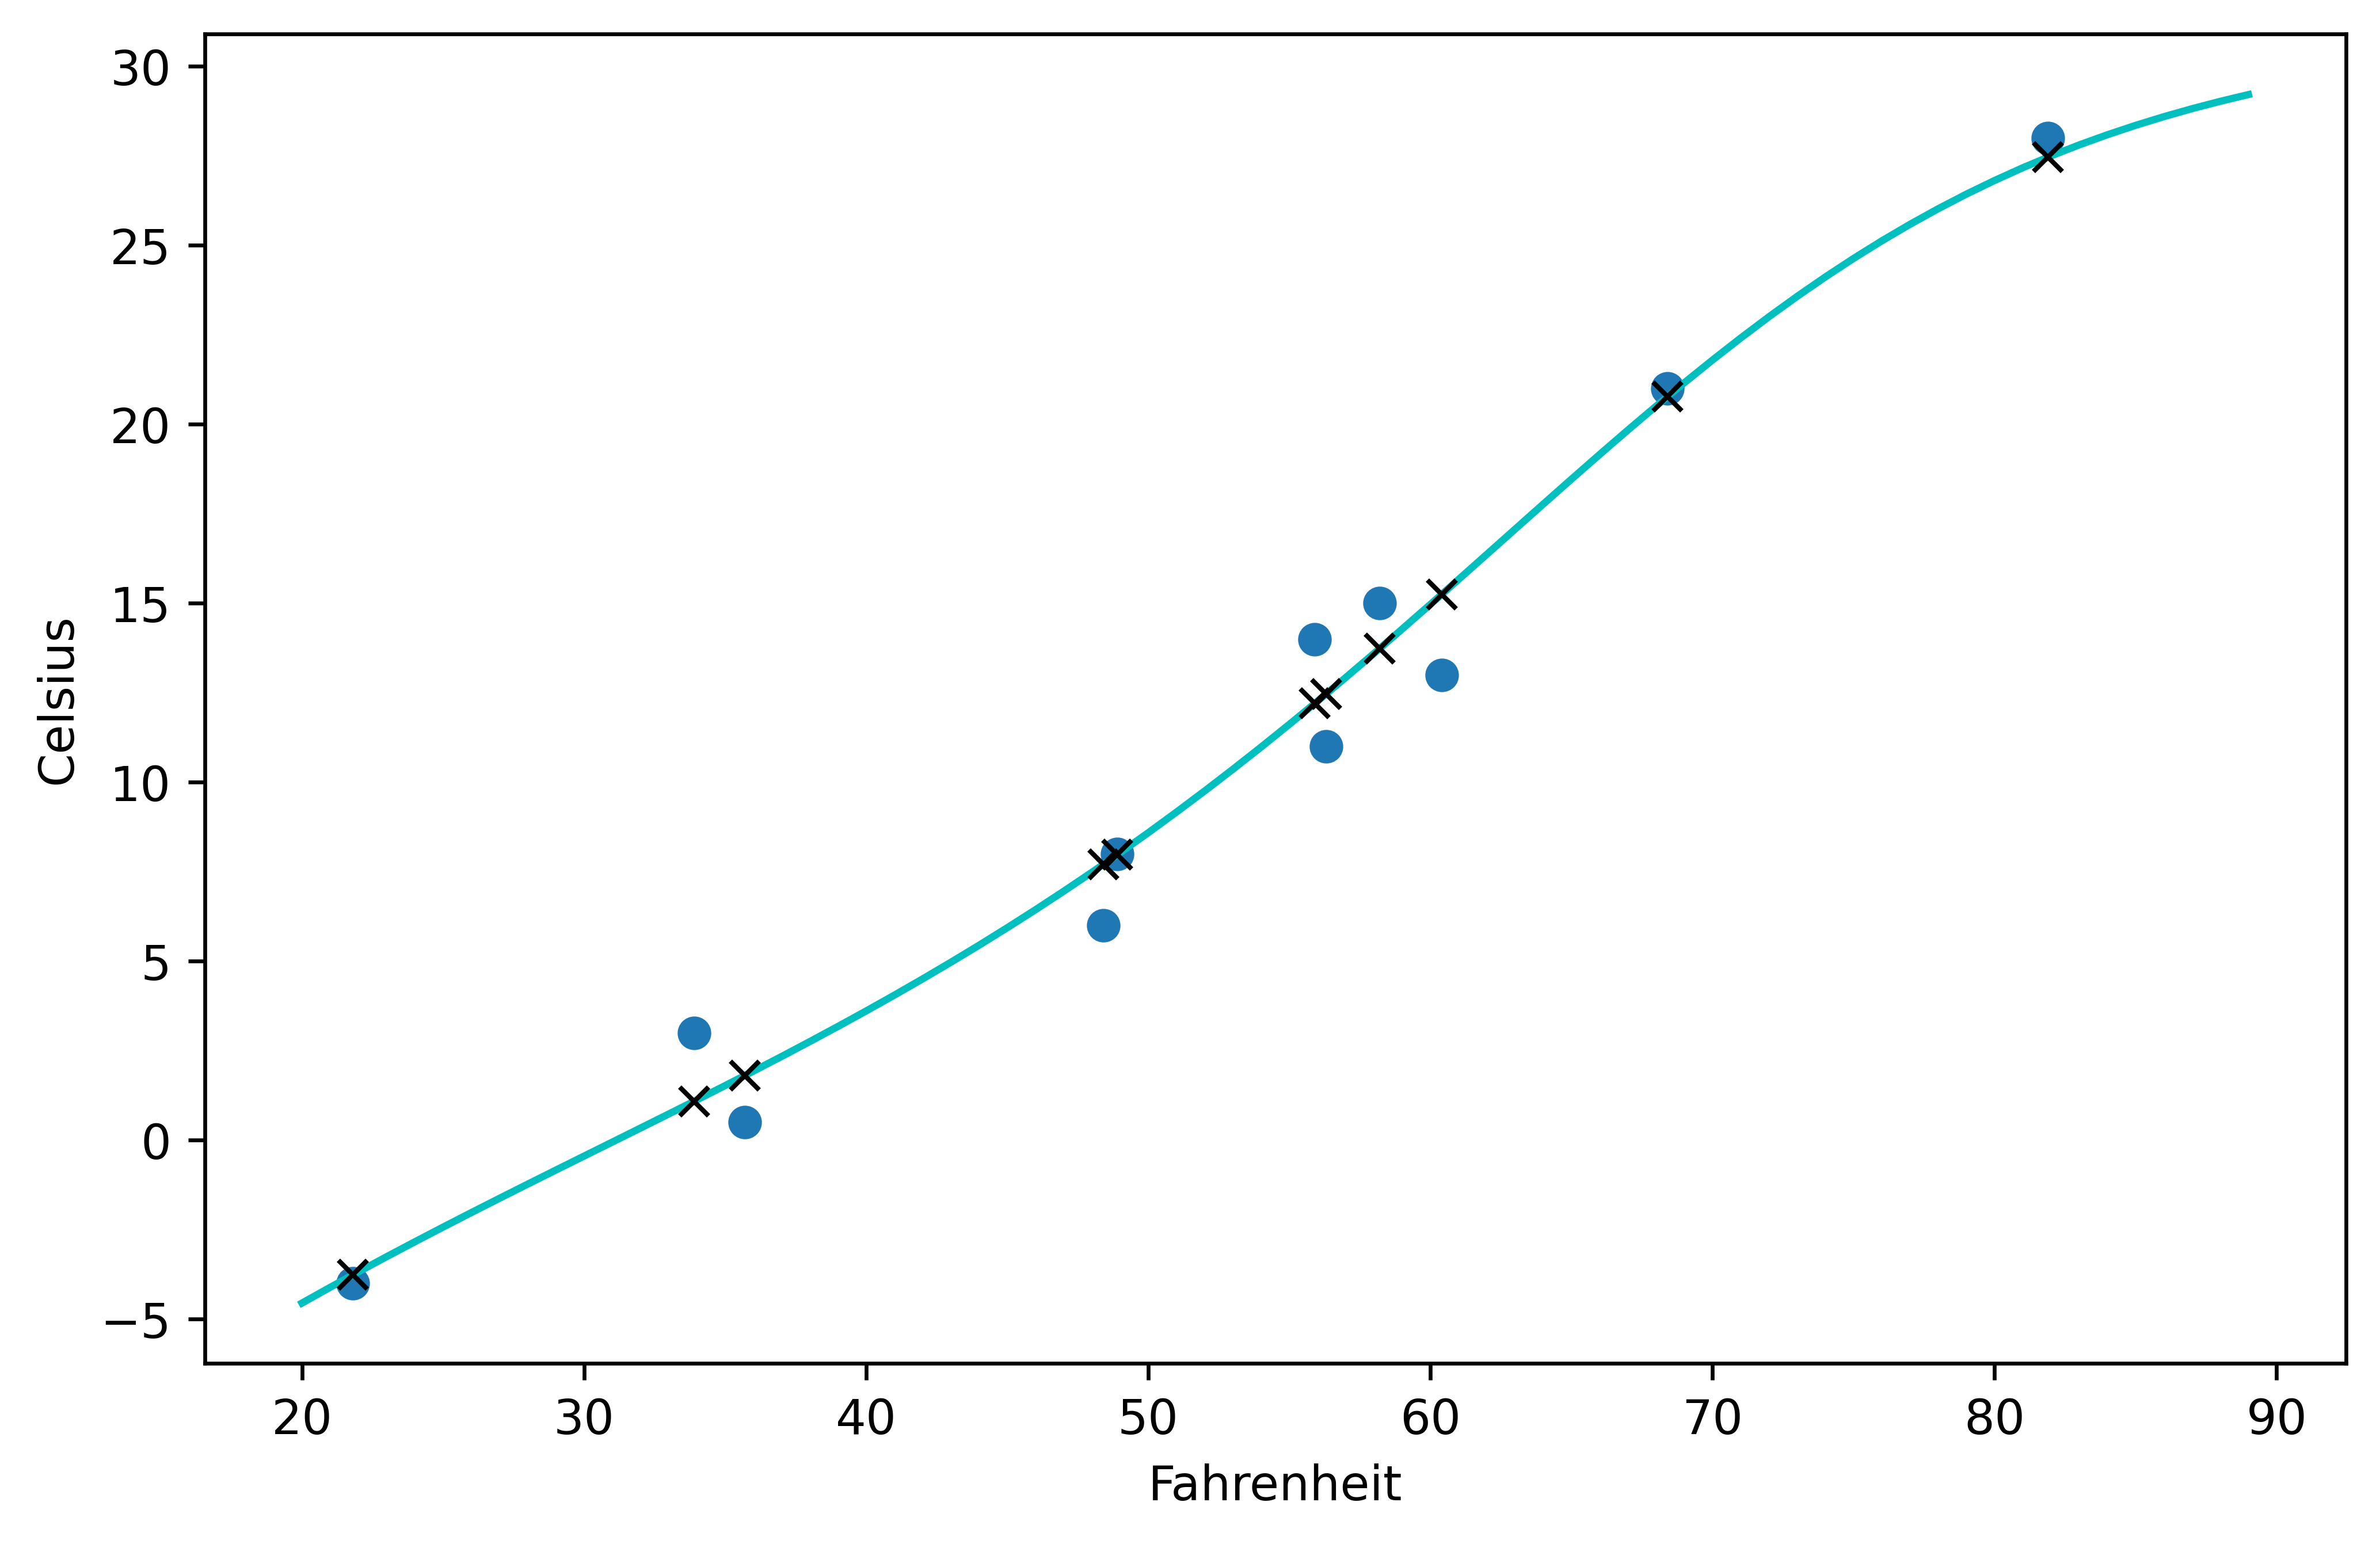

In [56]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600, figsize=(8,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')